# Step 2: Model Training and Hyperparameter Tuning
In this notebook, we train an XGBoost model to predict duplicate record pairs using the engineered features. We evaluate the model using metrics like ROC-AUC, Precision, Recall, and visualize its performance and tuning process.

We also apply Optuna for hyperparameter tuning and analyze feature importance.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, RocCurveDisplay
import xgboost as xgb
import optuna
import joblib
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Load pre-extracted features
df = pd.read_csv('../output/feature_matrix.csv')

# Split features and labels
X = df.drop(columns=['is_duplicate'])
y = df['is_duplicate']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X.shape, y.mean()

((2999, 2), np.float64(0.3001000333444481))

## Baseline XGBoost Model

In [29]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_prob))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))

ROC-AUC: 0.8973346560846561
Precision: 0.9150326797385621
Recall: 0.7777777777777778


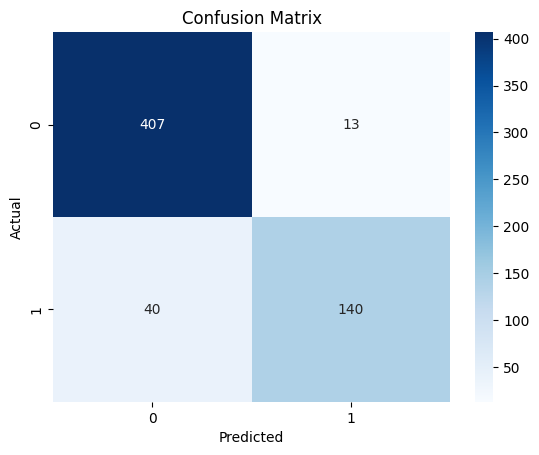

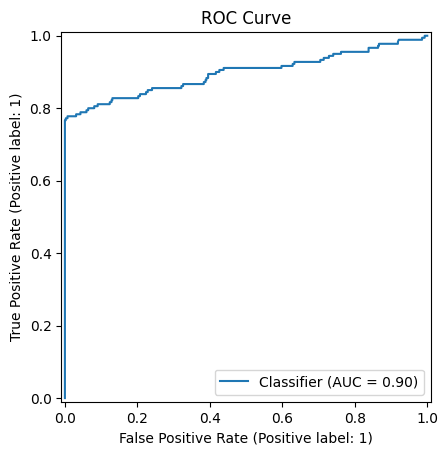

In [30]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RocCurveDisplay.from_predictions(y_val, y_prob)
plt.title('ROC Curve')
plt.show()

## Feature Importance

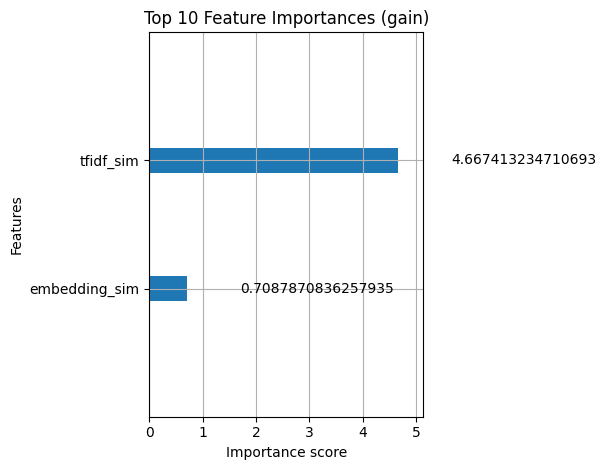

In [31]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances (gain)')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning with Optuna

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    bst = xgb.train(params, dtrain, evals=[(dvalid, 'eval')], num_boost_round=1000, early_stopping_rounds=50, verbose_eval=False)
    preds = bst.predict(dvalid)
    auc = roc_auc_score(y_val, preds)
    return auc

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

print("Best trial:")
print(study.best_trial)

[I 2025-05-16 17:25:06,204] A new study created in memory with name: no-name-07bfe46f-34a0-4cf4-9094-5e12efc06f87
[I 2025-05-16 17:25:09,202] Trial 0 finished with value: 0.8945568783068784 and parameters: {'learning_rate': 0.10584432211125323, 'max_depth': 3, 'subsample': 0.5021076596978249, 'colsample_bytree': 0.9818630138861533, 'lambda': 8.774908383207405, 'alpha': 3.193745828156512}. Best is trial 0 with value: 0.8945568783068784.
[I 2025-05-16 17:25:11,433] Trial 1 finished with value: 0.9010383597883597 and parameters: {'learning_rate': 0.06979980178172027, 'max_depth': 9, 'subsample': 0.8367540254656715, 'colsample_bytree': 0.9863178277337461, 'lambda': 0.21076180606624678, 'alpha': 0.5859349422355483}. Best is trial 1 with value: 0.9010383597883597.
[I 2025-05-16 17:25:15,905] Trial 2 finished with value: 0.9034126984126984 and parameters: {'learning_rate': 0.13569255532502264, 'max_depth': 7, 'subsample': 0.6113506419734052, 'colsample_bytree': 0.6014556384757399, 'lambda': 0

Best trial:
FrozenTrial(number=299, state=1, values=[0.9127910052910053], datetime_start=datetime.datetime(2025, 5, 16, 19, 44, 18, 681974), datetime_complete=datetime.datetime(2025, 5, 16, 19, 44, 19, 502296), params={'learning_rate': 0.18329166719912982, 'max_depth': 5, 'subsample': 0.7875657683344923, 'colsample_bytree': 0.7119018127646997, 'lambda': 0.028206051610646418, 'alpha': 0.001778750716888872}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.2, log=False, low=0.005, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'lambda': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'alpha': FloatDistribution(high=10.0, log=True, low=0.001, step=None)}, trial_id=299, value=None)


In [44]:
print("Best AUC:", study.best_value)
print("Best Parameters:", study.best_params)

Best AUC: 0.9127910052910053
Best Parameters: {'learning_rate': 0.18329166719912982, 'max_depth': 5, 'subsample': 0.7875657683344923, 'colsample_bytree': 0.7119018127646997, 'lambda': 0.028206051610646418, 'alpha': 0.001778750716888872}


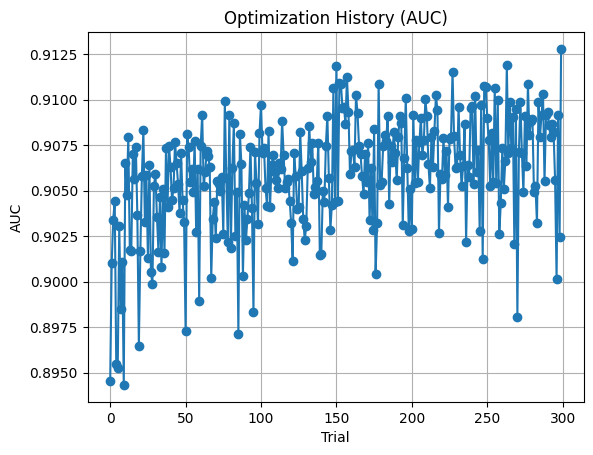

In [45]:
# Matplotlib visualization of optimization history
scores = [t.value for t in study.trials if t.value is not None]
plt.plot(scores, marker='o')
plt.title("Optimization History (AUC)")
plt.xlabel("Trial")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

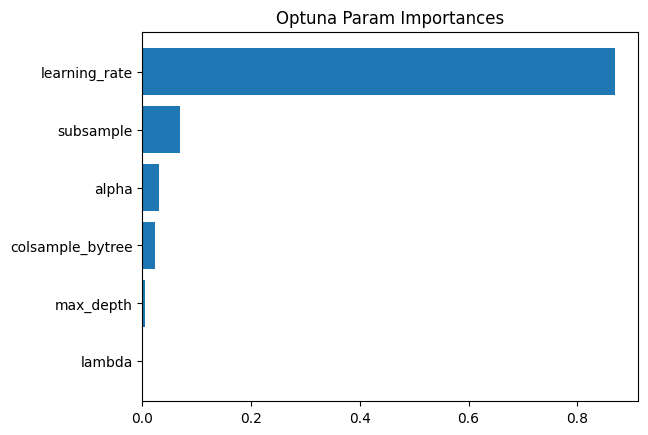

In [46]:
# Show parameter importance manually
from optuna.importance import get_param_importances
importances = get_param_importances(study)

# Plot
plt.barh(list(importances.keys()), list(importances.values()))
plt.title("Optuna Param Importances")
plt.gca().invert_yaxis()
plt.show()

## Final Model with Tuned Hyperparameters

In [43]:
best_params = study.best_trial.params

final_model = xgb.XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Huấn luyện không có early stopping
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

joblib.dump(final_model, '../src/trained_model.pkl')
print("Model saved to src/trained_model.pkl")

[0]	validation_0-logloss:0.49235
[1]	validation_0-logloss:0.44261
[2]	validation_0-logloss:0.40983
[3]	validation_0-logloss:0.38643
[4]	validation_0-logloss:0.36981
[5]	validation_0-logloss:0.33862
[6]	validation_0-logloss:0.31519
[7]	validation_0-logloss:0.30746
[8]	validation_0-logloss:0.29241
[9]	validation_0-logloss:0.28919
[10]	validation_0-logloss:0.27766
[11]	validation_0-logloss:0.27482
[12]	validation_0-logloss:0.27318
[13]	validation_0-logloss:0.26648
[14]	validation_0-logloss:0.26504
[15]	validation_0-logloss:0.25801
[16]	validation_0-logloss:0.25777
[17]	validation_0-logloss:0.25797
[18]	validation_0-logloss:0.25840
[19]	validation_0-logloss:0.25375
[20]	validation_0-logloss:0.25338
[21]	validation_0-logloss:0.25044
[22]	validation_0-logloss:0.25034
[23]	validation_0-logloss:0.24773
[24]	validation_0-logloss:0.24548
[25]	validation_0-logloss:0.24635
[26]	validation_0-logloss:0.24440
[27]	validation_0-logloss:0.24486
[28]	validation_0-logloss:0.24436
[29]	validation_0-loglos